# Анализ убытков приложения ProcrastinatePRO+

**Бизнес-задача**
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача проекта — разобраться в причинах и помочь компании выйти в плюс.

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.
В рамках проекта изучим, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

## Загрузка и подготовка данных к анализу
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный.

In [1]:
# Импортируем библиотеки
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Загружаем данные
visits = pd.read_csv(input())
orders = pd.read_csv(input())
costs = pd.read_csv(input())

In [3]:
# Последовательно взглянем на каждый датасет
for key, value in {'visits': visits, 'orders': orders, 'costs': costs}.items():
    print('\033[1m' + f'Вывод метода head() для таблицы {key}' + '\033[0m')
    display(value.head())
    print('\033[1m' + f'Вывод метода info() для таблицы {key}' + '\033[0m')
    print(value.info())
    print()

Вывод метода head() для таблицы visits


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Вывод метода info() для таблицы visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

Вывод метода head() для таблицы orders


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Вывод метода info() для таблицы orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

Вывод метода head() для таблицы costs


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Вывод метода info() для таблицы costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None



В представленных для анализа данных нет пропусков, однако колонки с датой и временем в датафрейме visits можно предварительно обработать: представим их в более удобном для анализа формате. Кроме того, названия столбцов нарушают конвенцию о наименованнии - исправим и это тоже.

In [4]:
visits = visits.rename(columns={'User Id':'user_id', 'Session Start':'session_start', 'Session End':'session_end'})
visits.columns = visits.columns.str.lower()

orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})

costs.columns = costs.columns.str.lower()

In [5]:
# Задаём необходимый формат
time_format = '%Y-%m-%d %H:%M:%S'

# Применяем формат к нужным столбцам
for col in ['session_start', 'session_end']:
    visits[col] = pd.to_datetime(visits[col], format = time_format)

# На всякий случай - повторим то же действие для остальных столбцов с датой и временем
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])
    
# Проверяем результат
display(visits.head())
display(orders.head())
display(costs.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Подготовка данных практически завершена. Необходимо проверить их на наличие дубликатов.
Определимся, что считать дубликатами:
* В датафрейме `visits` дубликатом будем считать совпадение времени для двух строк значений `user_id`, `session_start` и `session_end`.
* В датафреймах `orders` и `costs` дубликатом будем считать полное совпадение двух строк.

In [6]:
# Считаем долю дубликатов в visits
print(visits.duplicated(['user_id', 'session_start', 'session_end']).mean())

# И в orders и costs
print(orders.duplicated().mean())
print(costs.duplicated().mean())

0.0
0.0
0.0


Ни в одном из наборов данных дубликаты не обнаружены. Подведём промежуточные итоги.

**Промежуточный вывод**

Данные приведены к подходящему для анализа виду, дубликатов в данных не обнаружено. Можем перейти к исследовательскому анализу данных.

## Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Будем решать поставленные задачи по порядку. Для начала необходимо определить минимальную и максимальную дату привлечения пользователей.

Отметим, что минимальная дата в явном виде дана в описании проекта:
_с 2019-05-01 по 2019-10-27_

Максимальная дата **привлечения** не обязательно будет совпадать с максимальной датой в наборе данных, так что проверка не помешает.

Чтобы получить искомые данные, отсортируем данные в датафрейме `visits` по времени начала сессии, затем сгруппируем их по `user_id` и воспользумеся аггрегирующей функцией `first`.

In [7]:
# сортируем по началу сессии, чтобы для каждого юзера первой была его 1-я сессия 
# группируем по id пользователя
# сохраняем для пользователя только дату начала первой сессии
# снова сортируем, чтобы визуально определить самую раннюю и самую позднюю первую сессию
visits.sort_values(by='session_start') \
    .groupby('user_id') \
    .agg({'session_start': 'first'}) \
    .sort_values(by='session_start') 

,session_start
user_id,
382394863972,2019-05-01 00:00:41
428935481941,2019-05-01 00:01:35
86266511938,2019-05-01 00:02:38
763000657462,2019-05-01 00:04:21
791058813280,2019-05-01 00:05:17
...,...
598664469855,2019-10-27 23:55:23
18615786610,2019-10-27 23:55:42
430005587232,2019-10-27 23:56:13


Самая ранняя запись активности датируется первым мая 2019 года. Так как наши данные ограничены этой датой, нельзя с уверенностью сказать, были ли все пользователи, чья активность записана в этот день, привлечены именно тогда, но смиримся с этим ограничением.

Самая поздняя дата привлечения - первого взаимодействия пользователя с приложением - 27 октября 2019, и также совпадает с границей набора данных.

Теперь выясним, из каких стран приходят посетители - для этого проанализируем таблицу с информацией о визитах.

Интересующая нас переменная - `region`. На одном шаге найдём уникальные значения этой переменной и посчитаем, какое количество пользователей (*для этого оставим только уникальные пользовательские id - в противном случае получим число не пользователей, а собственно визитов*) приходится на каждую страну.

Чтобы упростить дальнейшие расчёты создадим новую таблицу users - пока оставим в ней только id пользователя и страну.

Для пущего удобства отсортируем данные по убыванию.

In [8]:
users = visits[['user_id', 'region']].drop_duplicates('user_id')

users_by_country = users.groupby('region').agg(unique_users = ('user_id', 'count')).sort_values(by = 'unique_users', ascending=False)
users_by_country['users_share'] = 100 * users_by_country['unique_users'] / users_by_country['unique_users'].sum()
users_by_country

,unique_users,users_share
region,,
United States,100002,66.664445
UK,17575,11.716042
France,17450,11.632713
Germany,14981,9.986801


Наибольшее количество пользователей приложения Procrastinate Pro+ - в США. Что насчёт платящих пользователей? Этот показатель можно оценить тремя способами:
1) Принять всех платящих пользователей за 100% и вывести **долю каждой страны** в общем их количестве.

2) Сравнить **число платящих пользователей** между странами.

3) Наконец, можно оценить **долю платящих пользователей в каждой стране** и сравнить эти доли между собой.

Для всех вариантов необходимо прежде всего определить платящих пользователей. В этом нам поможет таблица `orders`. Будем считать пользователя платящим, если его id представлен в этой таблице.

In [9]:
users['paying'] = users['user_id'].isin(orders['user_id'])
display(users.head())
print(users['paying'].mean())

,user_id,region,paying
0,981449118918,United States,False
1,278965908054,United States,False
2,590706206550,United States,False
3,326433527971,United States,False
4,349773784594,United States,False


0.05920350914617887


Лишь около 6 процентов пользователей из всей выборки - платящие. Посмотрим на разрез по странам.

In [10]:
users_by_country['paying_users'] = users.loc[users['paying']==True].groupby('region').agg(paying_users = ('user_id', 'count'))['paying_users']
users_by_country['paying_users_share'] = 100 * users_by_country['paying_users'] / users_by_country['paying_users'].sum()
users_by_country['country_pu_share'] = users.groupby('region').agg(pu_share = ('paying', 'mean'))['pu_share'] * 100
users_by_country

,unique_users,users_share,paying_users,paying_users_share,country_pu_share
region,,,,,
United States,100002,66.664445,6902,77.716473,6.901862
UK,17575,11.716042,700,7.881995,3.982930
France,17450,11.632713,663,7.465376,3.799427
Germany,14981,9.986801,616,6.936156,4.111875


США - лидер по всем показателям:
* Большая часть пользователей приходится на США
* Самое большое число платящих пользователей также приходится на США - причём доля страны в выборке платящих пользователей даже выше, чем в генеральной совокупности - на 11 процентных пунктов.
* Доля платящих пользователей в США максимальная и составляет почти 7%.

Используем похожий подход для оценки доли устройств, ответив на вопросы **"Какими устройствами они пользуются?"** и **"С каких устройств чаще всего заходят платящие пользователи?"**.

Для начала узнаем, сколько разных устройств приходится в среднем на одного пользователя.

In [11]:
visits.groupby('user_id').agg({'device': 'nunique'}).mean()

device    1.034551
dtype: float64

Больше одного - но незначительно. Выведем число уникальных пользователей по устройствам.

In [12]:
# Считаем пользователей
users_by_device = visits.groupby('device').agg(users_count = ('user_id', 'nunique')).sort_values(by='users_count', ascending=False)
users_by_device['device_share'] = users_by_device['users_count']/users_by_device['users_count'].sum()*100
users_by_device['pu_count'] = visits.loc[visits['user_id'].isin(orders['user_id'])].groupby('device').agg({'user_id': 'nunique'})['user_id']
users_by_device['pu_device_share'] = users_by_device['pu_count']/users_by_device['pu_count'].sum()*100
display(users_by_device)

,users_count,device_share,pu_count,pu_device_share
device,,,,
iPhone,55798,35.954405,3768,35.820896
Android,36377,23.440148,2458,23.367240
PC,31681,20.414199,1947,18.509364
Mac,31335,20.191248,2346,22.302500


In [13]:
# в среднем на пользователя приходится 2 визита
visits.groupby('device').agg({'user_id': ['nunique', 'count']})\
    .assign(visits_per_user=lambda row: row.iloc[:, 1] / row.iloc[:, 0])

user_id         visits_per_user
        nunique   count                
device                                 
Android   36377   72590        1.995492
Mac       31335   62022        1.979320
PC        31681   62686        1.978662
iPhone    55798  112603        2.018047

Самая "платящая" платформа - iPhone, за счёт более высокой доли в количестве посещений, именно на мобильные устройства компании Apple приходится большая (около трети) часть покупок.
Доли  трёх других типов устройств - Android, PC и Mac довольно близки (~20% как среди всех, так и среди платящих пользователей).

Два последних вопроса: "**По каким рекламным каналам шло привлечение пользователей?**" и "**Какие каналы приносят больше всего платящих пользователей?**".

Выясним, соответствует ли каждому пользователю только один канал привлечения.

In [14]:
visits.groupby('user_id').agg({'channel': 'nunique'}).mean()

channel    1.038718
dtype: float64

На одного пользователя приходится больше одного канала привлечения.

У этой проблемы есть несколько потенциальных решений:

*Решение 1.* Оставить для пользователя только **первый** канал привлечения

*Решение 2.* Исключить из подсчёта пользователей, у которых указано более одного канала привлечения

*Решение 3.* Считать не пользователей, а визиты, как приемлемый показатель при достаточно небольшом отклонении числа каналов на пользователя от единицы.

Так как третье решение уже испробовано в случае с устройствами, будем придерживаться его.

In [15]:
# Считаем пользователей
users_by_channel = visits.groupby('channel').agg(users_count = ('user_id', 'nunique')).sort_values(by='users_count', ascending=False)
users_by_channel['channel_share'] = users_by_channel['users_count']/users_by_channel['users_count'].sum()*100
users_by_channel['pu_count'] = visits.loc[visits['user_id'].isin(orders['user_id'])].groupby('channel').agg({'user_id': 'nunique'})['user_id']
users_by_channel['pu_channel_share'] = users_by_channel['pu_count']/users_by_channel['pu_count'].sum()*100
display(users_by_channel)

,users_count,channel_share,pu_count,pu_channel_share
channel,,,,
organic,57673,37.013529,1436,13.333333
FaceBoom,29916,19.199569,3832,35.580316
TipTop,20204,12.966576,2054,19.071495
OppleCreativeMedia,8929,5.730477,336,3.119777
LeapBob,8875,5.695821,365,3.389044
WahooNetBanner,8845,5.676567,538,4.995357
RocketSuperAds,4988,3.201212,558,5.181058
MediaTornado,4895,3.141526,392,3.639740
YRabbit,4882,3.133183,380,3.528319


Органический рост обеспечил солидную треть от всех визитов, но по своей природе он гененрирует меньше платящей аудитории. Треть визитов платящей аудитории в нашем случае обеспечена каналом TipTop.

In [16]:
users_by_channel\
    .assign(cr=lambda row: row['pu_count'] / row['users_count'])\
    .filter(like='cr')\
    .sort_values(by='cr', ascending=False)\
    .style.bar(color='#98C6FF')

,cr
channel,
lambdaMediaAds,0.134025
AdNonSense,0.132412
FaceBoom,0.128092
RocketSuperAds,0.111868
TipTop,0.101663
MediaTornado,0.080082
YRabbit,0.077837
WahooNetBanner,0.060825
LeapBob,0.041127


**Промежуточный вывод**

* Минимальная и максимальная даты привлечения пользователей: 01.05.2019, 27.10.2019.
* Наибольшее количество пользователей приложения Procrastinate Pro+ - в США
* Самое большое число платящих пользователей также приходится на США - причём доля страны в выборке платящих пользователей даже выше, чем в генеральной совокупности - на 11 процентных пунктов.
* Доля платящих пользователей в США максимальная и составляет почти 7%.
* Самая "платящая" платформа - iPhone, за счёт более высокой доли в количестве посещений, именно на мобильные устройства компании Apple приходится большая (около трети) часть покупок. Доли трёх других типов устройств - Android, PC и Mac довольно близки (~20% как среди всех, так и среди платящих пользователей).
* Органический рост обеспечил солидную треть от всех визитов, но по своей природе он гененрирует меньше платящей аудитории. Треть визитов платящей аудитории в нашем случае обеспечена каналом TipTop.

## Построение отчётов и расчёт метрик
Продукт:

-    Сколько людей пользуются в день, неделю, месяц?
-    Сколько сессий в день?
-    Сколько длится одна сессия?

Продажи:

- Когда люди начинают покупать?
- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?
- Какой средний чек за месяц, неделю, день?

Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Продукт:
-    Сколько людей пользуются в день, неделю, месяц?

In [17]:
# расширим таблицу visits - добавим в неё день (дату), неделю и месяц начала сессии. Год не нужен - все наши данные относятся к 2019 году
visits['date'] = visits['session_start'].dt.date
visits['week'] = visits['session_start'].dt.week
visits['month'] = visits['session_start'].dt.month
display(visits.head()) # всё работает, едем дальше

# считаем dau, wau, mau
print(visits.groupby('date').agg({'user_id': 'nunique'}).mean()) # dau
print(visits.groupby('week').agg({'user_id': 'nunique'}).mean()) # wau
print(visits.groupby('month').agg({'user_id': 'nunique'}).mean()) # mau

/tmp/ipykernel_27185/62190023.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits['week'] = visits['session_start'].dt.week


,user_id,region,device,channel,session_start,session_end,date,week,month
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01,2019-05-01,18,5
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35,2019-05-01,18,5
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08,2019-05-01,18,5
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25,2019-05-01,18,5
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40,2019-05-01,18,5


user_id    1684.23913
dtype: float64
user_id    8353.777778
dtype: float64
user_id    28989.166667
dtype: float64


Среднее число уникальных пользователей приложения:
* В день: 1684
* В неделю: 8354
* В месяц: 28989

Дополнительно построим графики `DAU`, `WAU` и `MAU` для представления об их динамике.

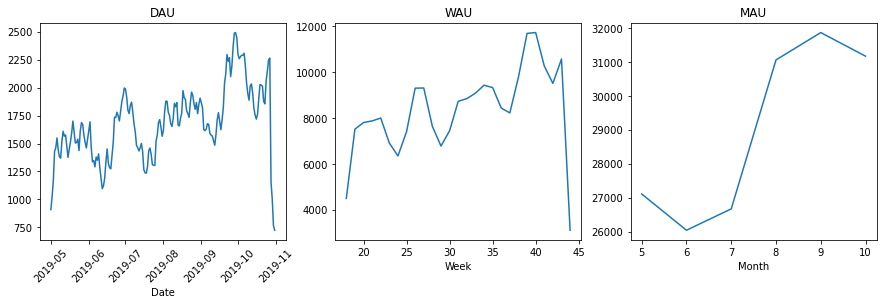

In [18]:
# три раза строить график лениво, напишем функцию, которая сделает это за нас
def make_plot(data, period, measure):
    if period == 'Date':
        plt.plot(data.groupby('date').agg({'user_id': measure}))
        plt.title('DAU')
        plt.xticks(rotation=45)
    elif period == 'Week':
        plt.plot(data.groupby('week').agg({'user_id': measure}))
        plt.title('WAU')
    elif period == 'Month':
        plt.plot(data.groupby('month').agg({'user_id': measure}))
        plt.title('MAU')
    plt.xlabel(period)

plt.figure(figsize=(15, 4))
ax1 = plt.subplot(1, 3, 1)
make_plot(visits, 'Date', 'nunique')
ax2 = plt.subplot(1, 3, 2)
make_plot(visits, 'Week', 'nunique')
ax3 = plt.subplot(1, 3, 3)
make_plot(visits, 'Month', 'nunique')

plt.show()

# На графики можно добавить сетку, можно принудительно задать точку отсчёта для шкалы y в 0,
# наконец, можно отбросить неполные начальный и заключительный периоды.
# Но для всего, кроме последнего, ценность неочевидна, а последнее можно учитывать при анализе.

Наибольшее число уникальных пользователей наблюдалось в последние три месяца, для которых доступны данные.
При этом в `DAU` и `WAU` наблюдаются локальные просадки  в июне, июле и сентябре (25, 30 и 36 недели).

-    Сколько сессий в день?

Для ответа на вопрос построим гистограмму и посчитаем среднее количество сессий в день.

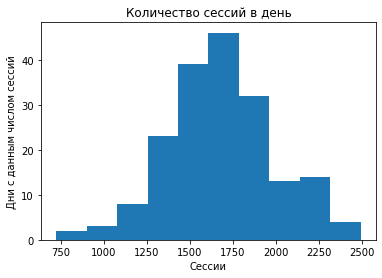

In [19]:
plt.hist(x=visits.groupby('date').aggregate({'user_id': 'count'})['user_id'])
plt.title('Количество сессий в день')
plt.xlabel('Сессии')
plt.ylabel('Дни с данным числом сессий');

In [20]:
print(visits.groupby('date').aggregate({'user_id': 'count'}).mean())

user_id    1684.244565
dtype: float64


Распределение количества сессий в день формой напоминает нормальное _(но не является нормальным в строго математическом смысле слова)_, таким образом среднее - подходящая метрика для его оценки.

Удивительным образом, средее число сессий в день лишь немного превосходит средее число пользователей в день. Подавляющее большинство пользователей ограничивается одной сессией.

-    Сколько длится одна сессия?

Аналогично предыдущему пункту построим гистограмму и посчитаем среднюю длительность сессии.

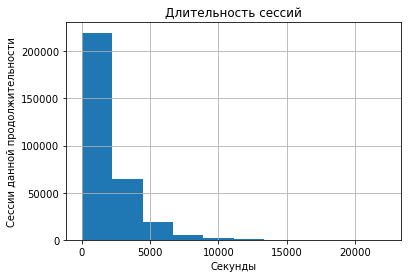

In [21]:
# можем ещё дополнить таблицу visits и добавить в неё разность между концом и началом сессии
visits['session_length'] = visits['session_end'] - visits['session_start']
visits['session_length'].dt.total_seconds().hist()
plt.title('Длительность сессий')
plt.xlabel('Секунды')
plt.ylabel('Сессии данной продолжительности');

В случае с продолжительностью сессии одним средним уже не обойтись - этот показатель будет спещён вправо, так как распределение показателя имеет длинный хвост значений.

In [22]:
# Воспользуемся методом describe - таким образом получим всю информацию о распределении одной командой.
print(visits['session_length'].describe())

count                       309901
mean     0 days 00:30:00.090867728
std      0 days 00:30:03.063524541
min                0 days 00:00:00
25%                0 days 00:08:37
50%                0 days 00:20:44
75%                0 days 00:41:37
max                0 days 06:10:57
Name: session_length, dtype: object


В среднем одна пользовательская сессия длится около 30 минут, медианное время - 21 минута.

### Продажи:

- Когда люди начинают покупать?

Иными словами, нам нужно понять, сколько времени в среднем проходит с момента первого посещения до покупки.
Чуть раньше мы уже выделили время первой сессии для каждого пользователя, и, независимо от этого, создали датафрейм с пользовательской информацией.
Дополним датафрейм `users` датой первого визита в приложении, а также - где применимо - датой первого платежа из таблицы `orders`.

In [23]:
# users = visits[['user_id', 'region']].drop_duplicates('user_id')
# users['paying'] = users['user_id'].isin(orders['user_id'])

users = users.merge(visits.sort_values(by='session_start') \
    .groupby('user_id') \
    .agg({'session_start': 'first'}),
                   on='user_id')

users = users.merge(orders.sort_values(by='event_dt') \
     .groupby('user_id') \
     .agg({'event_dt':'first'}),
                    how='left',
                    on='user_id')

users = users.rename(columns={'session_start': 'first_session', 'event_dt': 'first_payment'})

users['timedelta'] = users['first_payment'] - users['first_session']

users.loc[users['paying']]

,user_id,region,paying,first_session,first_payment,timedelta
24,188246423999,United States,True,2019-05-01 23:09:42,2019-05-01 23:09:52,0 days 00:00:10
29,784885401335,United States,True,2019-05-01 13:25:07,2019-05-02 06:30:36,0 days 17:05:29
41,172680080954,United States,True,2019-05-01 00:32:55,2019-05-08 04:14:21,7 days 03:41:26
90,648972875590,United States,True,2019-05-01 05:33:05,2019-05-03 00:50:22,1 days 19:17:17
91,174361394180,United States,True,2019-05-01 12:23:47,2019-05-01 12:24:04,0 days 00:00:17
...,...,...,...,...,...,...
149903,76856793223,UK,True,2019-10-27 21:09:01,2019-10-28 17:30:12,0 days 20:21:11
149936,170195900174,UK,True,2019-10-27 22:29:32,2019-10-27 22:30:00,0 days 00:00:28
149955,335693479362,Germany,True,2019-10-27 19:02:47,2019-10-27 19:03:22,0 days 00:00:35
149957,486975740490,Germany,True,2019-10-27 03:17:15,2019-10-28 03:38:27,1 days 00:21:12


count                         8881
mean     1 days 21:11:20.986488008
std      6 days 00:52:20.045661202
min                0 days 00:00:00
25%                0 days 00:00:10
50%                0 days 00:00:33
75%                1 days 11:28:01
max              132 days 03:54:33
Name: timedelta, dtype: object


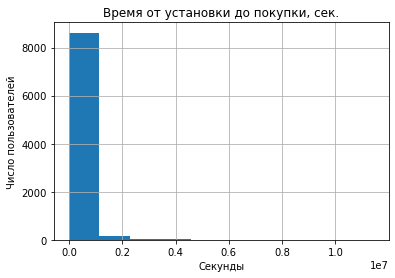

In [24]:
print(users['timedelta'].describe())
users['timedelta'].dt.total_seconds().hist()
plt.title('Время от установки до покупки, сек.')
plt.xlabel('Секунды')
plt.ylabel('Число пользователей');

В среднем, между установкой приложения и первой покупкой в нём проходит почти 2 дня. Однако распределение сильно смещено - и медиана, составляющая 1 минуту и 10 секунд, является более надёжным показателем.

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

Для этих метрик также построим графики изменения во времени.

In [25]:
# разложим переменную event_dt в таблице orders на дату, неделю и месяц
orders['date'] = orders['event_dt'].dt.date
orders['week'] = orders['event_dt'].dt.week
orders['month'] = orders['event_dt'].dt.month

/tmp/ipykernel_27185/4053111710.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  orders['week'] = orders['event_dt'].dt.week


In [26]:
# Посчитаем среднее число покупок на пользователя в день, неделю и месяц
print(orders.groupby(['user_id', 'date']).agg({'event_dt':'count'})['event_dt'].mean())
print(orders.groupby(['user_id', 'week']).agg({'event_dt':'count'})['event_dt'].mean())
print(orders.groupby(['user_id', 'month']).agg({'event_dt':'count'})['event_dt'].mean())

1.0000497388709277
1.3062205619619944
2.182232593476963


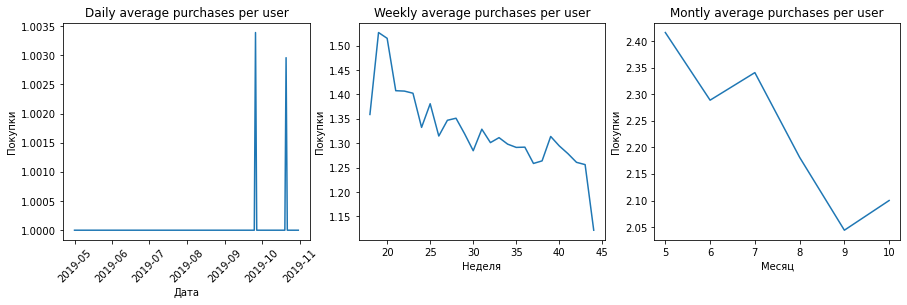

In [27]:
# построим графики
plt.figure(figsize=(15, 4))
ax1 = plt.subplot(1, 3, 1)
plt.plot(orders.groupby(['user_id', 'date']).agg({'event_dt':'count'}).groupby('date').mean())
plt.xticks(rotation=45)
plt.title('Daily average purchases per user')
plt.ylabel('Покупки')
plt.xlabel('Дата')
ax2 = plt.subplot(1, 3, 2)
plt.plot(orders.groupby(['user_id', 'week']).agg({'event_dt':'count'}).groupby('week').mean())
plt.title('Weekly average purchases per user')
plt.ylabel('Покупки')
plt.xlabel('Неделя')
ax3 = plt.subplot(1, 3, 3)
plt.plot(orders.groupby(['user_id', 'month']).agg({'event_dt':'count'}).groupby('month').mean())
plt.title('Montly average purchases per user')
plt.ylabel('Покупки')
plt.xlabel('Месяц')

plt.show()

# Я как будто ошибся в первом (там, где daily)
# Мысль моя думается в таком направлении: кого мы считаем платящим пользователем на конкретную дату? 
# Если того, кто совершил покупку в эту конкретную дату, то да, получается в среднем по одной в день.
# Но может быть и сложнее: платящий пользователь на конкретную дату это пользователь, 
# который совершил покупку в эту или любую предыдущую дату и был активен в эту или любую последующую дату.
# Но кажется, что я слишком усложняю, и надо уже сдавать проект, а не размышлять о тонких материях

В среднем в день платящий пользователь совершает одну покупку, в неделю - 1.3 покупки, в месяц - 2.2. Однако, во-первых, в разрезе дня есть два пика в сентябре и октябре, а во-вторых: количество покупок в среднем на платящего пользователя неуклонно снижается в разрезе недель и месяцев.

Посмотрим на динамику среднего чека.

- Какой средний чек за месяц, неделю, день?

In [28]:
print(orders.groupby(['date']).agg({'revenue':'mean'}).mean())
print(orders.groupby(['week']).agg({'revenue':'mean'}).mean())
print(orders.groupby(['month']).agg({'revenue':'mean'}).mean())

revenue    5.375884
dtype: float64
revenue    5.376336
dtype: float64
revenue    5.374169
dtype: float64


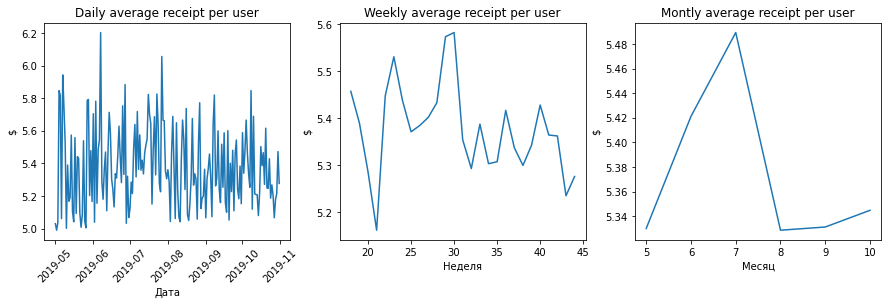

In [29]:
# построим графики
plt.figure(figsize=(15, 4))
ax1 = plt.subplot(1, 3, 1)
plt.plot(orders.groupby(['date']).agg({'revenue':'mean'}))
plt.xticks(rotation=45)
plt.title('Daily average receipt per user')
plt.xlabel('Дата')
plt.ylabel('\$')
ax2 = plt.subplot(1, 3, 2)
plt.plot(orders.groupby(['week']).agg({'revenue':'mean'}))
plt.title('Weekly average receipt per user')
plt.xlabel('Неделя')
plt.ylabel('\$')
ax3 = plt.subplot(1, 3, 3)
plt.plot(orders.groupby(['month']).agg({'revenue':'mean'}))
plt.title('Montly average receipt per user')
plt.xlabel('Месяц')
plt.ylabel('\$')

plt.show()

Средний чек достигает максимальной суммы (превышая 5.5 долларов) в июне-июле, на 23, 29 и 30 неделях, затем падает в августе ниже 5.4 долларов.

### Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени

Помимо подсчёта показателей, также отобразим их изменение во времени.

In [30]:
print(costs['costs'].sum())

105497.30000000002


Всего на привлечение пользователей потратили 105.5 тысяч долларов.

In [31]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Больше всего потратили на привлечение пользователей из TipTop и FaceBoom.

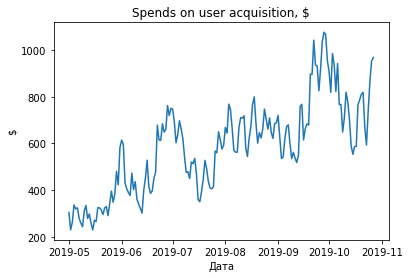

In [32]:
plt.plot(costs.groupby('dt').agg({'costs':'sum'}))
plt.title('Spends on user acquisition, $')
plt.xlabel('Дата')
plt.ylabel('\$')
plt.show()

Сумма расходов на привлечение пользователей показывает тенденцию к росту. Рассмотрим каналы по отдельности.

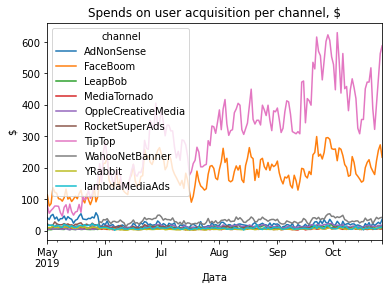

In [33]:
costs.pivot_table(values='costs', index='dt', columns='channel', aggfunc='sum').plot()
plt.title('Spends on user acquisition per channel, $')
plt.xlabel('Дата')
plt.ylabel('\$')
plt.show()

Сумма ежедневных расходов на привлечение пользователей стабильна для большинства каналов, однако FaceBoom и TipTop показывают постоянный рост.
Рассчитаем CAC.

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

In [34]:
print('Средняя стоимость привлечения пользователя:', costs['costs'].sum()/len(users))

channel_costs_split = costs.groupby('channel') \
    .agg({'costs':'sum'}) \
    .sort_values(by='costs', ascending=False) \
    .reset_index() \
    .merge(users_by_channel.reset_index()[['channel', 'users_count']], on='channel')

channel_costs_split['cac'] = channel_costs_split['costs'] / channel_costs_split['users_count']
channel_costs_split

Средняя стоимость привлечения пользователя: 0.703277825182657


,channel,costs,users_count,cac
0,TipTop,54751.30,20204,2.709924
1,FaceBoom,32445.60,29916,1.084557
2,WahooNetBanner,5151.00,8845,0.582363
3,AdNonSense,3911.25,4199,0.931472
4,OppleCreativeMedia,2151.25,8929,0.240928
5,RocketSuperAds,1833.00,4988,0.367482
6,LeapBob,1797.60,8875,0.202546
7,lambdaMediaAds,1557.60,2410,0.646307
8,MediaTornado,954.48,4895,0.194991
9,YRabbit,944.22,4882,0.193408


В среднем привлечение пользователя стоит компании 7 центов.
Наиболее дорогие источники - TipTop и FaceBoom, пользователи из которых стоят 2.71 и 1.08 долларов соответственно, AdNonSense близок к FaceBoom со стоимостю привлечения пользователя равной 93 центам.

**Промежуточные выводы**

Среднее число уникальных пользователей приложения:

*    В день: `1684`
*    В неделю: `8354`
*    В месяц: `28989`

Число пользователей приложения довольно стабильно росло примерно до сентября 2019, затем стабилизировалось у отметки 31-32 тыс. пользователей.

Подавляющее большинство пользователей ограничивается одной сессией - среднее число сессий в приложении в день также равно `1684`.

Одна пользовательская сессия в среднем длится около 30 минут, медианное время - 21 минута.

В среднем, между установкой приложения и первой покупкой в нём проходит почти 2 дня. Однако распределение сильно смещено - и медиана, составляющая 1 минуту и 10 секунд, является более надёжным показателем.

В среднем в день платящий пользователь совершает одну покупку, в неделю - 1.3 покупки, в месяц - 2.2. Однако, во-первых, в разрезе дня есть два пика в сентябре и октябре, а во-вторых: количество покупок в среднем на платящего пользователя неуклонно снижается в разрезе недель и месяцев.

Средний пользовательский чек показывает ту же самую тенденцию к снижению в анализе по неделям и месяцам.
Средний дневной чек составляет 5.37 доллара, средний недельный чек - 7.02 доллара, средний месячный чек - 11.72 доллара.

Всего на привлечение пользователей потратили 105.5 тысяч долларов. Большая часть этой суммы приходится на каналы TipTop и FaceBoom.

Сумма расходов на привлечение пользователей показывает тенденцию к росту. Сумма ежедневных расходов на привлечение пользователей стабильна для большинства каналов, однако упомянутые выше FaceBoom и TipTop показывают постоянный рост.

В среднем привлечение пользователя стоит компании 7 центов. Наиболее дорогие источники - TipTop и FaceBoom, пользователи из которых стоят 2.71 и 1.08 долларов соответственно, AdNonSense близок к FaceBoom со стоимостю привлечения пользователя равной 93 центам.

Перейдём к следующему шагу и создадим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

## Создание функций для расчета и анализа LTV, ROI, удержания и конверсии

In [35]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [36]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [37]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [38]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [39]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [40]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [41]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [42]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Промежуточные выводы**

Функции для дальнейшего анализа данных созданы, можно перейти к оценке окупаемости рекламы для привлечения пользователей.

## Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишем проблемы, которые обнаружили. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела. Окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

Прежде всего сохраним текущую дату и заложим горизонт анализа, а также подготовим данные для дальнейшего анализа - выполним функцию `get_profiles` над нашими данными.

In [43]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
profiles = get_profiles(visits, orders, costs)

### Проанализируем общую окупаемость рекламы

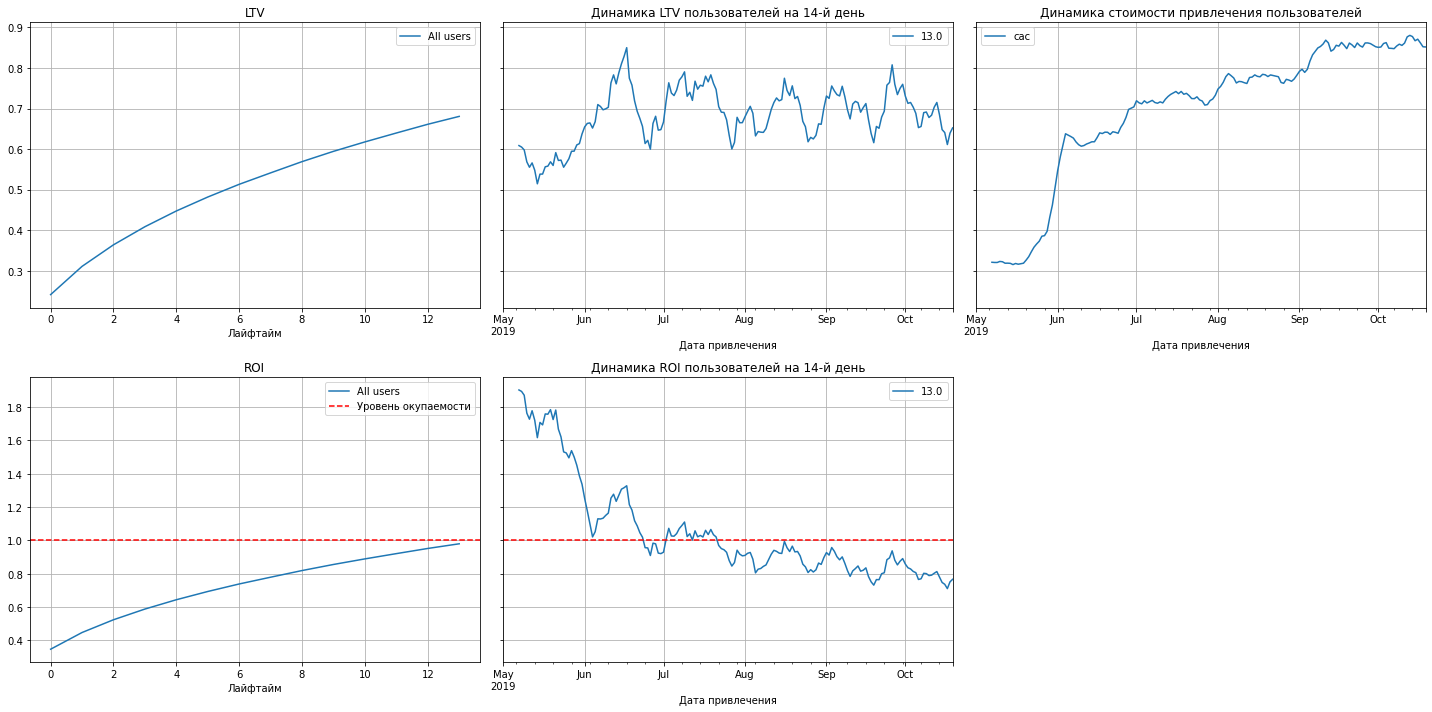

In [44]:
# смотрим на общую картину - окупается ли реклама в общем?
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

На графиках заметно, что реклама в целом не окупается - `CAC` постоянно растёт, ROI на 14 день снижается и перестаёт достигать уровня окупаемости в конце июля.

Для выяснения причин необходимо оценить показатели в различных разрезах.

Проанализируем окупаемость рекламы с разбивкой по устройствам.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

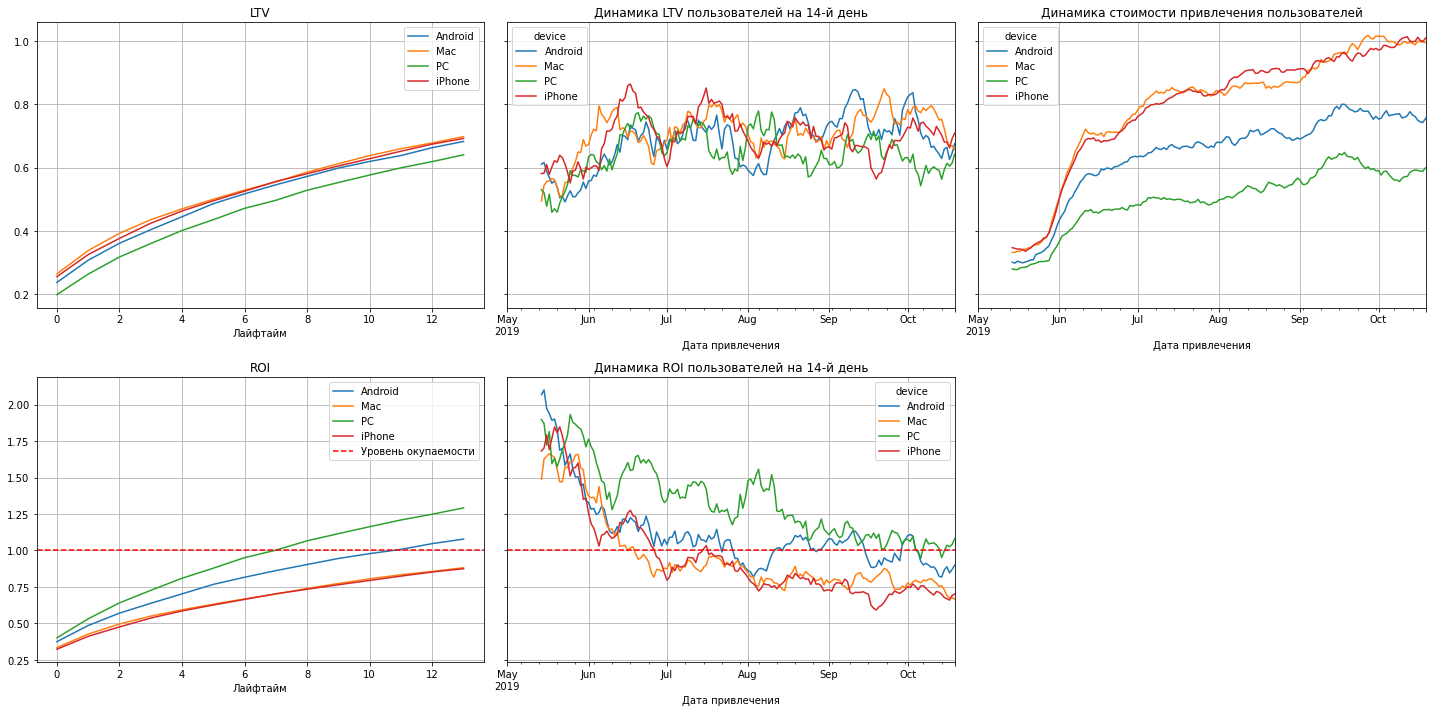

In [45]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Пользователи PC, хоть и показывают минимальный LTV, дешевле в привлечении и достигают уровня окупаемости на 7 день. Следуют за ними пользователи Android, достигающие окупаемости на 11 день. Пользователи Mac и iPhone уровня окупаемости не достигают - они очень дороги, а их LTV отличается от двух других групп незначительно.

Проанализируем окупаемость рекламы с разбивкой по странам.

### Проанализируем окупаемость рекламы с разбивкой по странам

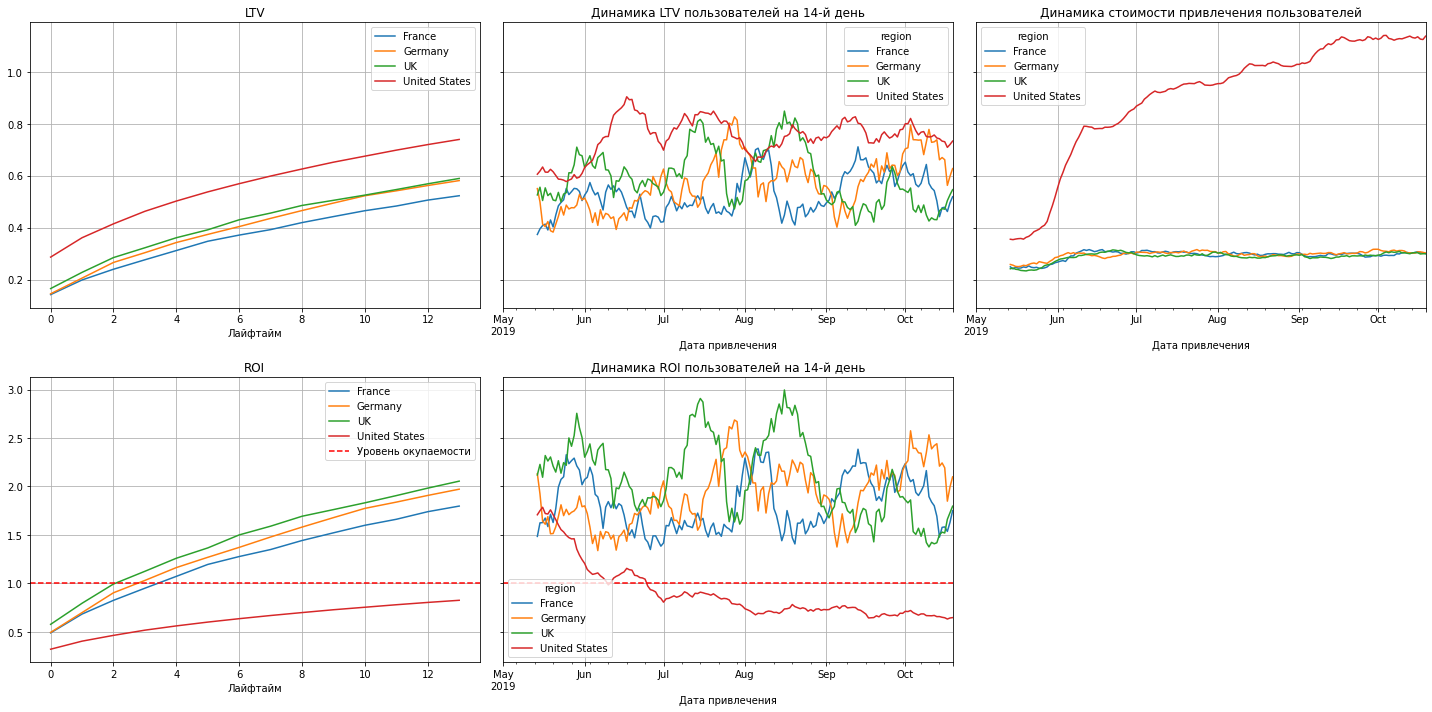

In [46]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Наиболее "дороги" пользователи из США - они не достигают уровня окупаемости, даже показывая сравнительно высокий LTV, а показатель ROI для пользователей из этой страны не достигает уровня окупаемости с июля 2019.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

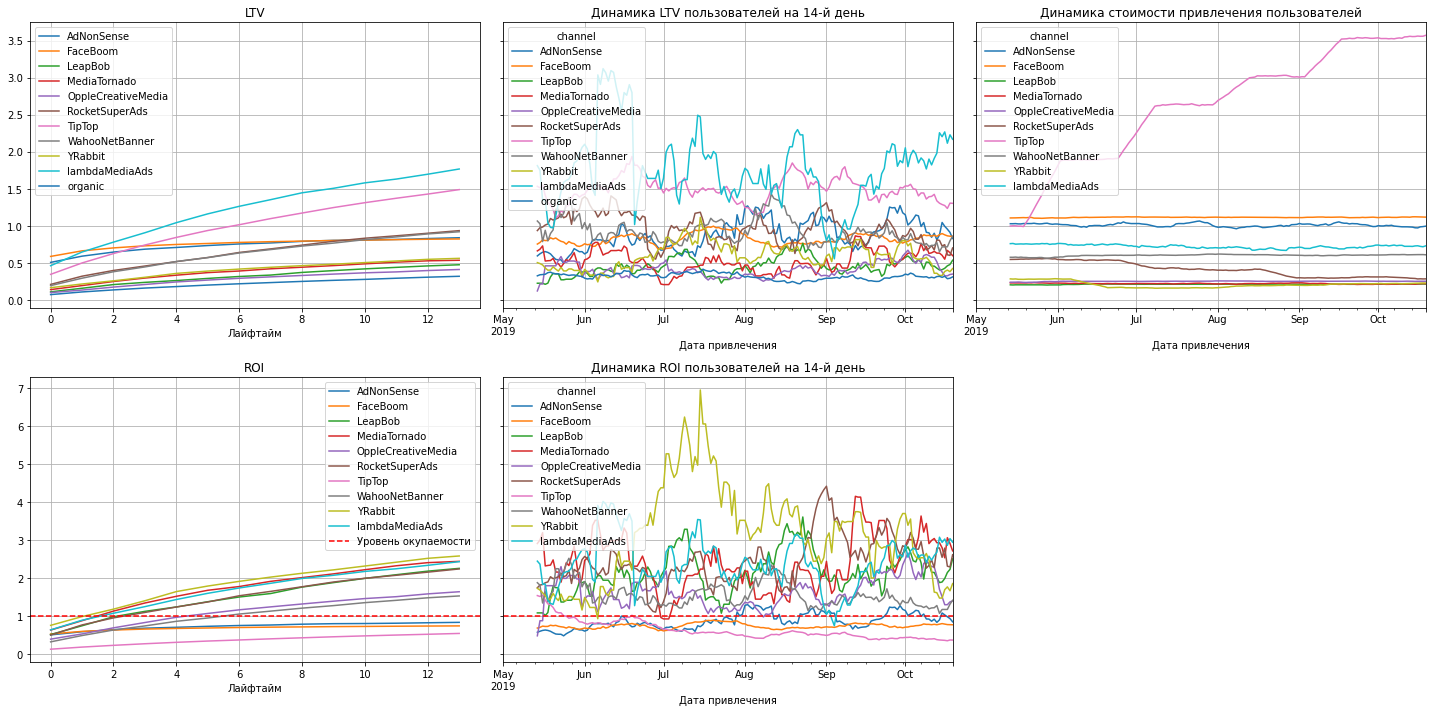

In [47]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

ROI пользователей, привлечённых из нескольких каналов, не достигают уровня окупаемости. В первую очередь нужно отметить канал TipTop - стоимость привлечения пользователей из него только растёт, что сводит "на нет" сравнительно высокий LTV. Другой проблемный канал - FaceBoom; стоимость привлечения в нём довольно стабильна, однако LTV низок. Также не достигают уровня окупаемости к 14 дню пользователи, привлечённые из канала AdNonSense.

### Чем могут быть вызваны проблемы окупаемости? 

Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

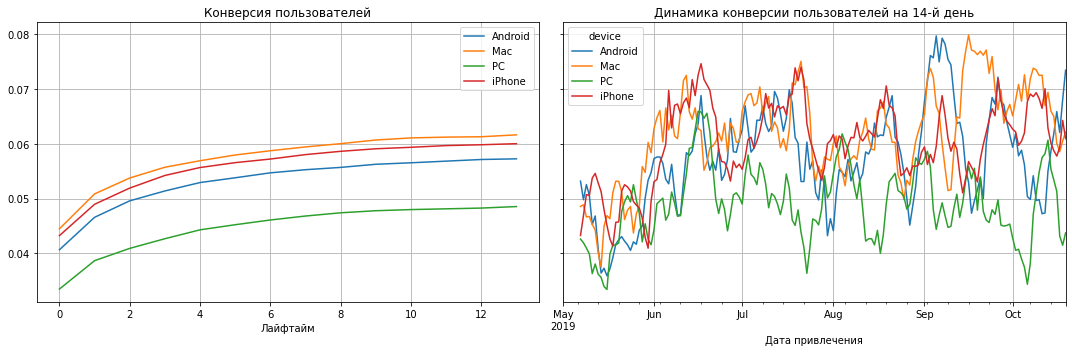

In [48]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей на Mac и iPhone высокая - выше, чем пользователей Android и PC. При этом в динамике особых закономерностей не видно - на всех четырёх типах устройств наблюдаются как подъёмы, так и спады.

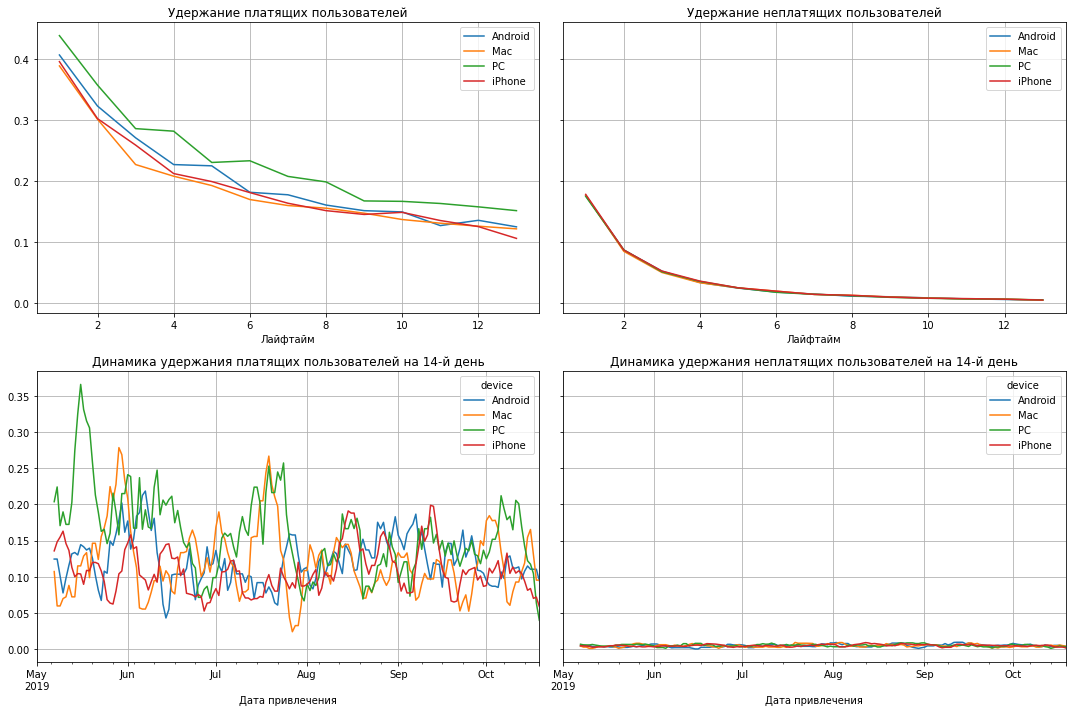

In [49]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Несколько иная ситуация с удержанием. Удержание неплатящих пользователей низкое, и до конца второй недели не доживает и 1% привлечённых пользователей, вне зависимости от канала.

Что касается платящих пользователей, то самый высокий показатель удержания - у PC, на любой день лайфтайма. Пользователи Android, Mac и iPhone практически не отличаются с точки зрения удержания.

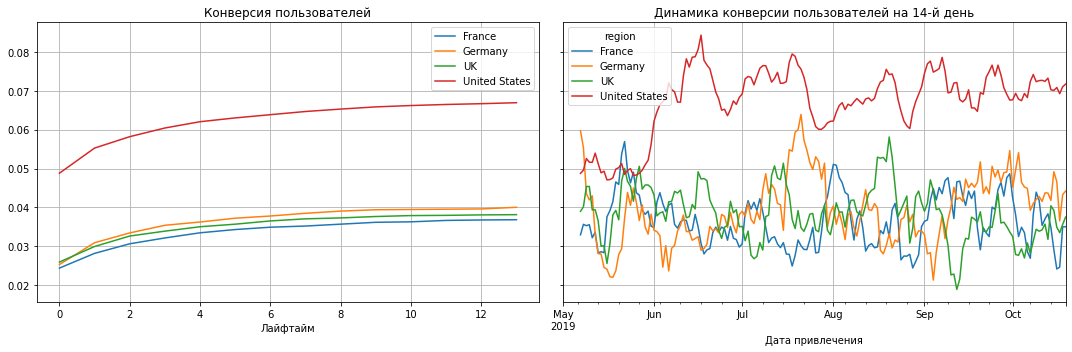

In [50]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей из США - максимальная, и к окончанию двухнедельного окна почти достигает 7%. Ни одна европейская страна не может похвастаться такими же показателями.

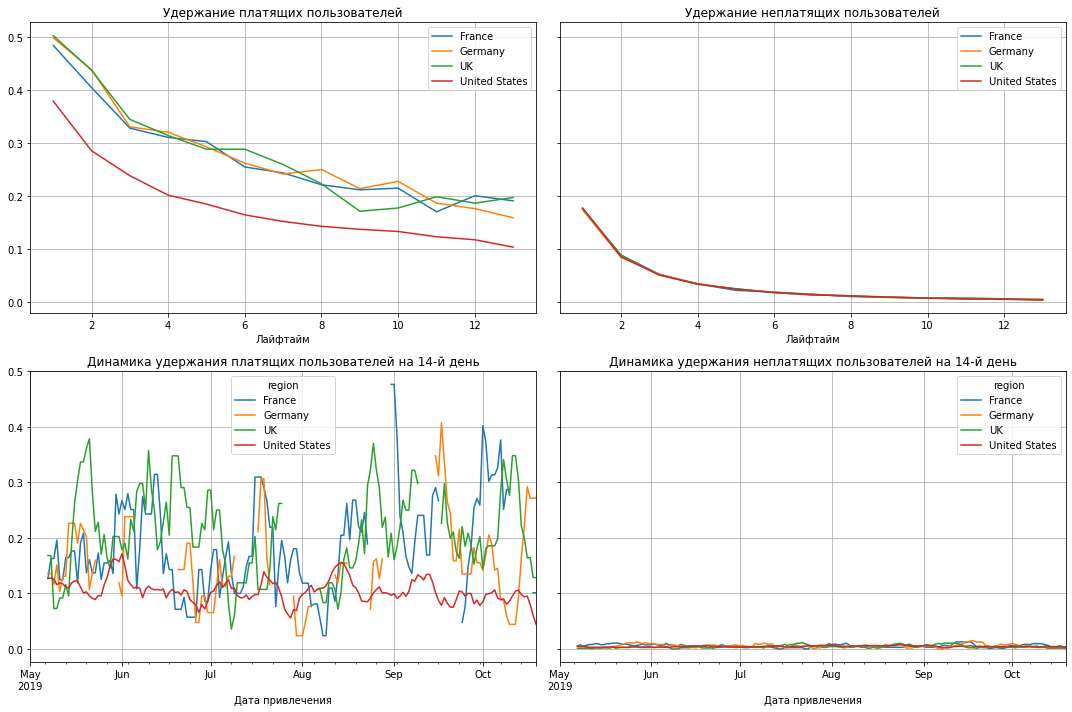

In [51]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Высокая конверсия американцев, однако, нивелируется низким показателем удержания. Возможно, приложение плохо адаптировано для США (например, в приложении используется метрическая система, либо технические работы на серверах происходят по европейскому времени, выпадая на часы высокой активности пользователей из США).

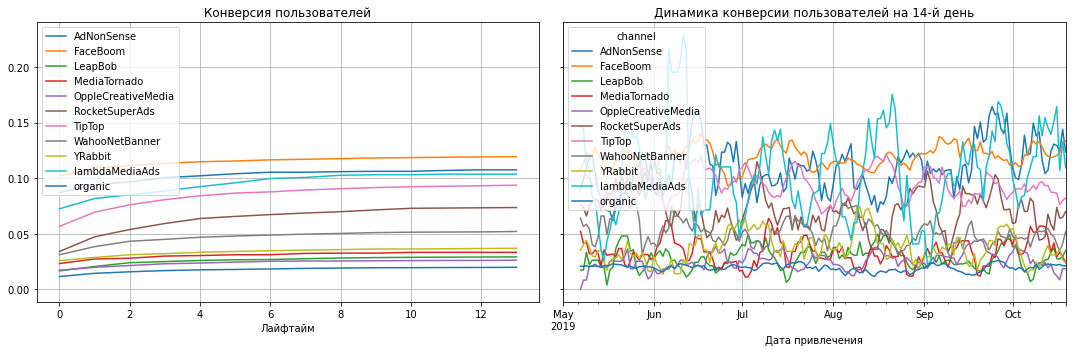

In [52]:
# смотрим конверсию с разбивкой по рекламным каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Наилучшую конверсию пользователей показывает Faceboom - даже в 1 день она достигает 10%, однако практически не показывает тенденцию к росту и демонстрирует довольно ровную динамику на 14 день.

В группе лидеров по конверсии также находятся каналы AdNonSense, lambdaMediaAds и TipTop, но динамика конверсии в них схожа с динамикой конверсии Faceboom, и ни один из этих каналов не показывает таких же результатов на 14 день. 

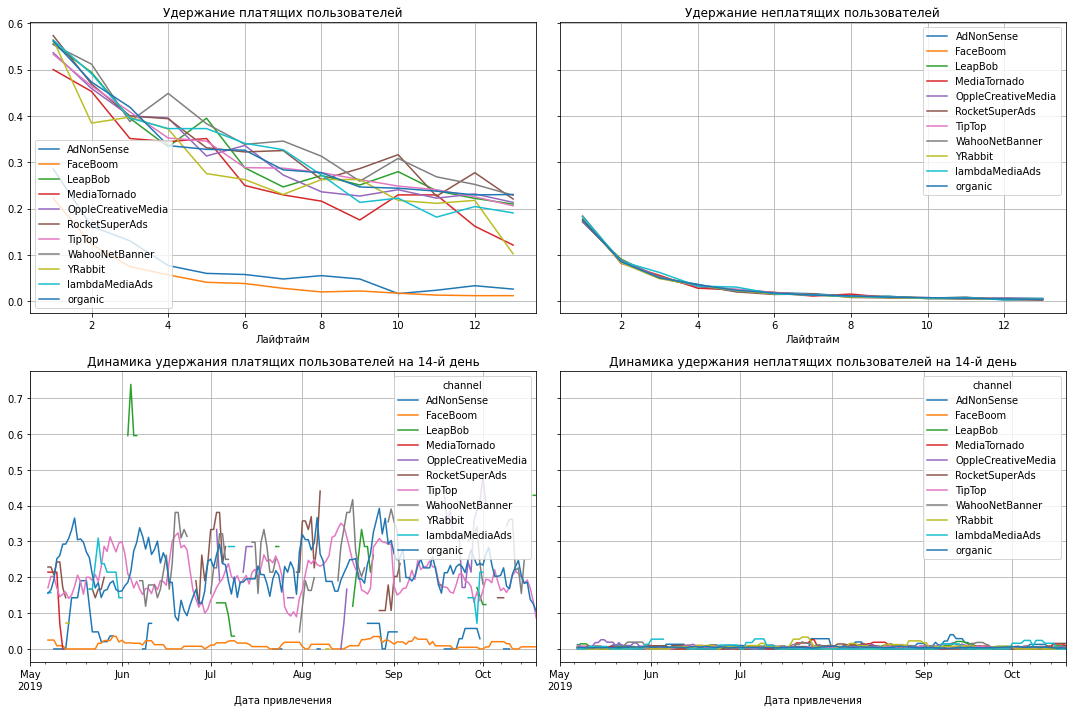

In [53]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Хорошие результаты FaceBoom в смысле привлечения пользователей нивелируются низким уровнем удержания - сравнится с этим каналом может лишь AdNonSense. Проблемный во многих смыслах канал TipTop в смысле удержания не хуже основной массы каналов.

### Основные выводы

**Основные причины неэффективности привлечения пользователей**

1) Основная масса пользователей привлекается из двух каналов: `FaceBoom` и `TipTop`. Недостатки этих каналов отличаются: `TipTop` отличается высоким (и растущим!) показателем `CAC`, тогда как `FaceBoom` обладает стабильным `CAC`, но является антилидером по показателю удержания платящих пользователей.

2) Наиболее дороги для привлечения пользователи из США (и в пользовательской базе приложения их большинство), однако высокий уровень конверсии не позволяет им окупаться. Причина в низком удержании пользователей. Причина может носить продуктовый характер (например, технические работы на серверах приложения происходят в часы высокой активности в США, или же приложение плохо адаптировано к американскому рынку).

3) На фоне других разрезов, устройство пользователя менее значимо при оценке успешности рекламной кампании, однако стоит отметить сравнительно более высокую стоимость привлечения пользователей Mac и iPhone по сравнению с PC и Android, а также низкую конверсию пользователей PC (нельзя не отметить при этом более высокий показатель удержания для последних).

Динамика увеличения `CAC`, наблюдаемая в США и для пользователей TipTop может означать, что ресурс целевой ("core") аудитории приложения там уже выбран, и компании приходится платить за привлечение всё более редких пользователей. Это может быть хорошим сигналом к тому, что бюджеты кампаний необходимо перераспределить.

**Рекомендации для отдела маркетинга**
В последующих рекламных кампаниях необходимо сфокусироваться на устройствах, каналах и странах, которые достигают уровня окупаемости в пределах двух недель, а именно:
1) Устройства - PC и Android;

2) Каналы - большинство, за исключением FaceBoom, TipTop и AdNonSense;

3) Европейские страны.